In [1]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Novel_Muzzle_Dataset_NN.zip

Archive:  /content/drive/MyDrive/Novel_Muzzle_Dataset_NN.zip
   creating: Novel_Muzzle_Dataset_NN/testing/
   creating: Novel_Muzzle_Dataset_NN/testing/C-01/
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0008_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0009_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0010_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0015_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0018_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0024_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0027_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0028_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0031_crop.jpg  
  inflating: Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0049_crop.jpg  
   creating: Novel_Muzzle_Dataset_NN/testing/C-02/
  inflating: Novel_Muzzle_Dataset_NN/testing/C-02/augmented_image_4.jpg  
  infla

In [5]:
def load_dataset(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    for cattle_folder in sorted(os.listdir(dataset_path)):
        cattle_folder_path = os.path.join(dataset_path, cattle_folder)
        for image_name in sorted(os.listdir(cattle_folder_path)):
            image_path = os.path.join(cattle_folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(cattle_folder)
    images = np.array(images)
    labels = np.array(labels)

    return images, labels
test_path = "/content/Novel_Muzzle_Dataset_NN/testing"
train_path = "/content/Novel_Muzzle_Dataset_NN/training"
train_images, train_labels = load_dataset(train_path)
print("Loaded", len(train_images), "images with corresponding", len(train_labels), "labels.")
test_images, test_labels =  load_dataset(test_path)
print("Loaded", len(test_images), "images with corresponding", len(test_labels), "labels.")

Loaded 2000 images with corresponding 2000 labels.
Loaded 500 images with corresponding 500 labels.


In [6]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
train_labels= train_labels.reshape(-1, 1)
print(train_labels.shape)

(2000, 1)


In [7]:
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_labels)
test_labels= test_labels.reshape(-1, 1)
print(test_labels.shape)

(500, 1)


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)
data_augmentation.layers[0].adapt(train_images)

In [9]:
input_shape=(128,128,3)
num_classes=50

In [10]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cattle-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


In [11]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cattle-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [12]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                

In [13]:
margin = 0.1
dynamic_temperature = False

In [14]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

class CustomNPairLoss(keras.losses.Loss):
    def __init__(self, temperature=1, margin=0.1, dynamic_temperature=False, name=None):
        super().__init__(name=name)
        self.temperature = temperature
        self.margin = margin
        self.dynamic_temperature = dynamic_temperature

    def __call__(self, y_true, y_pred, sample_weight=None):
        labels = tf.squeeze(y_true)
        feature_vectors_normalized = tf.math.l2_normalize(y_pred, axis=1)
        logits_normalized = tf.divide(
            tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
            self.temperature if not self.dynamic_temperature else self.temperature(labels, logits)
        )
        npair_loss = tfa.losses.npairs_loss(labels, logits_normalized)
        margin_term = tf.maximum(0.0, self.margin - tf.linalg.diag_part(logits_normalized))
        total_loss = npair_loss + tf.reduce_mean(margin_term)
        return total_loss

class CombinedLoss(keras.losses.Loss):
    def __init__(self, temperature_sc=1, temperature_np=1, margin=0.1, dynamic_temperature=False, name=None):
        super().__init__(name=name)
        self.temperature_sc = temperature_sc
        self.temperature_np = temperature_np
        self.margin = margin
        self.dynamic_temperature = dynamic_temperature
        self.supervised_contrastive_loss = SupervisedContrastiveLoss(temperature_sc)
        self.custom_npair_loss = CustomNPairLoss(temperature_np, margin, dynamic_temperature)

    def __call__(self, y_true, y_pred, sample_weight=None):
        sc_loss = self.supervised_contrastive_loss(y_true, y_pred)
        np_loss = self.custom_npair_loss(y_true, y_pred)
        combined_loss = sc_loss + np_loss
        return combined_loss

def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cattle-encoder_with_projection-head"
    )
    return model

In [15]:
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
     loss=CombinedLoss(temperature, margin, dynamic_temperature),
)

history = encoder_with_projection_head.fit(
    train_images, train_labels, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/50
8/8 [==============================] - 64s 2s/step - loss: 8.3921
Epoch 2/50
8/8 [==============================] - 6s 697ms/step - loss: 6.4522
Epoch 3/50
8/8 [==============================] - 6s 701ms/step - loss: 5.3336
Epoch 4/50
8/8 [==============================] - 6s 707ms/step - loss: 4.8469
Epoch 5/50
8/8 [==============================] - 6s 716ms/step - loss: 4.5382
Epoch 6/50
8/8 [==============================] - 6s 713ms/step - loss: 4.2239
Epoch 7/50
8/8 [==============================] - 6s 721ms/step - loss: 4.1348
Epoch 8/50
8/8 [==============================] - 6s 727ms/step - loss: 3.9714
Epoch 9/50
8/8 [==============================] - 6s 735ms/step - loss: 3.9890
Epoch 10/50
8/8 [==============================] - 6s 742ms/step - loss: 3.9070
Epoch 11/50
8/8 [==============================] - 6s 740ms/step - loss: 3.9008
Epoch 12/50
8/8 [==============================] - 6s 735ms/step - loss: 3.8187
Epoch 13/50
8/8 [==============================] - 

In [16]:
classifier = create_classifier(encoder, trainable=False)
history = classifier.fit(train_images, train_labels, batch_size=batch_size, epochs=num_epochs)
accuracy = classifier.evaluate(test_images, test_labels)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
8/8 [==============================] - 5s 203ms/step - loss: 5.3063 - sparse_categorical_accuracy: 0.1440
Epoch 2/50
8/8 [==============================] - 2s 207ms/step - loss: 2.5453 - sparse_categorical_accuracy: 0.4475
Epoch 3/50
8/8 [==============================] - 2s 211ms/step - loss: 1.5940 - sparse_categorical_accuracy: 0.6340
Epoch 4/50
8/8 [==============================] - 2s 207ms/step - loss: 1.0193 - sparse_categorical_accuracy: 0.7595
Epoch 5/50
8/8 [==============================] - 2s 208ms/step - loss: 0.7339 - sparse_categorical_accuracy: 0.8190
Epoch 6/50
8/8 [==============================] - 2s 209ms/step - loss: 0.5202 - sparse_categorical_accuracy: 0.8645
Epoch 7/50
8/8 [==============================] - 2s 210ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.8975
Epoch 8/50
8/8 [==============================] - 2s 209ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8995
Epoch 9/50
8/8 [==============================] - 2s 211ms/step 

In [17]:
numerical_predictions = classifier.predict(test_images)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print(decoded_predictions)

16/16 [==============================] - 1s 35ms/step
['C-01' 'C-01' 'C-01' 'C-01' 'C-01' 'C-01' 'C-01' 'C-01' 'C-01' 'C-01'
 'C-02' 'C-02' 'C-02' 'C-02' 'C-02' 'C-02' 'C-02' 'C-02' 'C-02' 'C-02'
 'C-03' 'C-03' 'C-03' 'C-03' 'C-03' 'C-03' 'C-03' 'C-03' 'C-03' 'C-03'
 'C-04' 'C-04' 'C-04' 'C-04' 'C-04' 'C-04' 'C-04' 'C-04' 'C-04' 'C-04'
 'C-05' 'C-05' 'C-05' 'C-05' 'C-05' 'C-05' 'C-05' 'C-05' 'C-05' 'C-05'
 'C-06' 'C-06' 'C-06' 'C-06' 'C-06' 'C-06' 'C-06' 'C-06' 'C-06' 'C-06'
 'C-07' 'C-07' 'C-07' 'C-07' 'C-07' 'C-07' 'C-07' 'C-07' 'C-07' 'C-07'
 'C-08' 'C-08' 'C-08' 'C-08' 'C-08' 'C-08' 'C-08' 'C-08' 'C-08' 'C-08'
 'C-09' 'C-09' 'C-09' 'C-09' 'C-09' 'C-09' 'C-09' 'C-09' 'C-09' 'C-09'
 'C-10' 'C-10' 'C-10' 'C-10' 'C-10' 'C-10' 'C-10' 'C-10' 'C-10' 'C-10'
 'C-11' 'C-11' 'C-11' 'C-11' 'C-11' 'C-11' 'C-11' 'C-11' 'C-11' 'C-11'
 'C-12' 'C-12' 'C-12' 'C-12' 'C-12' 'C-12' 'C-12' 'C-12' 'C-12' 'C-12'
 'C-13' 'C-13' 'C-13' 'C-13' 'C-13' 'C-13' 'C-13' 'C-13' 'C-13' 'C-13'
 'C-14' 'C-14' 'C-14' '

In [18]:
test_labels = label_encoder.inverse_transform(test_labels)

In [19]:
test_labels

array(['C-01', 'C-01', 'C-01', 'C-01', 'C-01', 'C-01', 'C-01', 'C-01',
       'C-01', 'C-01', 'C-02', 'C-02', 'C-02', 'C-02', 'C-02', 'C-02',
       'C-02', 'C-02', 'C-02', 'C-02', 'C-03', 'C-03', 'C-03', 'C-03',
       'C-03', 'C-03', 'C-03', 'C-03', 'C-03', 'C-03', 'C-04', 'C-04',
       'C-04', 'C-04', 'C-04', 'C-04', 'C-04', 'C-04', 'C-04', 'C-04',
       'C-05', 'C-05', 'C-05', 'C-05', 'C-05', 'C-05', 'C-05', 'C-05',
       'C-05', 'C-05', 'C-06', 'C-06', 'C-06', 'C-06', 'C-06', 'C-06',
       'C-06', 'C-06', 'C-06', 'C-06', 'C-07', 'C-07', 'C-07', 'C-07',
       'C-07', 'C-07', 'C-07', 'C-07', 'C-07', 'C-07', 'C-08', 'C-08',
       'C-08', 'C-08', 'C-08', 'C-08', 'C-08', 'C-08', 'C-08', 'C-08',
       'C-09', 'C-09', 'C-09', 'C-09', 'C-09', 'C-09', 'C-09', 'C-09',
       'C-09', 'C-09', 'C-10', 'C-10', 'C-10', 'C-10', 'C-10', 'C-10',
       'C-10', 'C-10', 'C-10', 'C-10', 'C-11', 'C-11', 'C-11', 'C-11',
       'C-11', 'C-11', 'C-11', 'C-11', 'C-11', 'C-11', 'C-12', 'C-12',
      

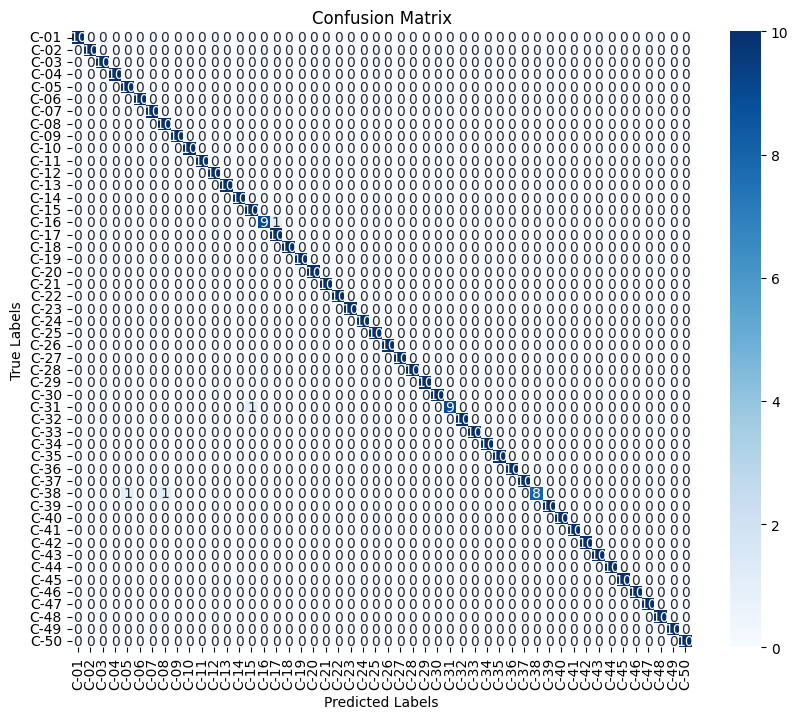

In [20]:
cm = confusion_matrix(test_labels, decoded_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

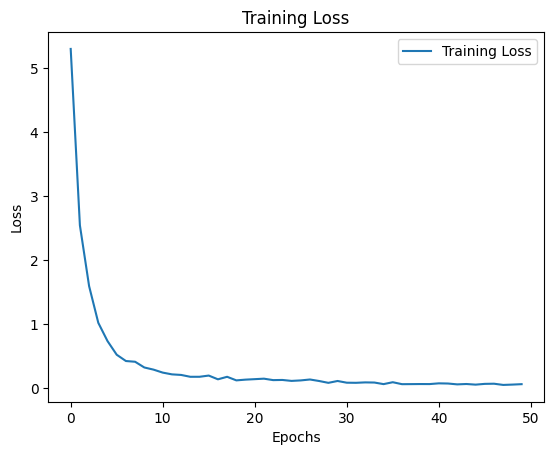

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

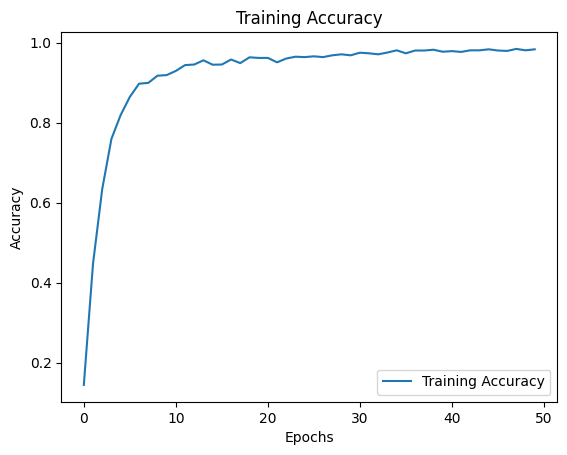

In [22]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [23]:
report = classification_report(test_labels, decoded_predictions)
print(report)
file_path = "classification_report_128.txt"
with open(file_path, "w") as file:
    file.write(report)
print("Classification report saved to:", file_path)

              precision    recall  f1-score   support

        C-01       1.00      1.00      1.00        10
        C-02       1.00      1.00      1.00        10
        C-03       1.00      1.00      1.00        10
        C-04       1.00      1.00      1.00        10
        C-05       0.91      1.00      0.95        10
        C-06       1.00      1.00      1.00        10
        C-07       1.00      1.00      1.00        10
        C-08       0.91      1.00      0.95        10
        C-09       1.00      1.00      1.00        10
        C-10       1.00      1.00      1.00        10
        C-11       1.00      1.00      1.00        10
        C-12       1.00      1.00      1.00        10
        C-13       1.00      1.00      1.00        10
        C-14       1.00      1.00      1.00        10
        C-15       0.91      1.00      0.95        10
        C-16       1.00      0.90      0.95        10
        C-17       0.91      1.00      0.95        10
        C-18       1.00    

In [24]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-05/C-05_0001_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 2s 2s/step
Predicted class: ['C-05']


In [25]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0008_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 46ms/step
Predicted class: ['C-19']


In [26]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-01/C-01_0008_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 30ms/step
Predicted class: ['C-19']


In [27]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/training/C-04/C-04_0004_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 31ms/step
Predicted class: ['C-38']


In [28]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-10/C-10_0008_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 34ms/step
Predicted class: ['C-15']


In [29]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-06/C-06_0004_crop.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 22ms/step
Predicted class: ['C-21']


In [30]:
random_image_path = "/content/Novel_Muzzle_Dataset_NN/testing/C-14/augmented_image_0.jpg"
random_image = load_img(random_image_path, target_size=(128, 128))
random_image_array = img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)
numerical_predictions = classifier.predict(random_image_array)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels.flatten())
print("Predicted class:", decoded_predictions)

1/1 [==============================] - 0s 24ms/step
Predicted class: ['C-11']


In [35]:
numerical_predictions = classifier.predict(test_images)
predicted_labels = np.argmax(numerical_predictions, axis=1)
decoded_predictions = label_encoder.inverse_transform(predicted_labels)
predicted_labels, decoded_predictions

16/16 [==============================] - 1s 39ms/step


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 16, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
        22, 

In [36]:
unique_predictions, unique_indices = np.unique(decoded_predictions, axis=0, return_index=True)
unique_ground_truth_labels = test_labels[unique_indices]

In [37]:
len(unique_predictions)

50

In [38]:
len(unique_ground_truth_labels)

50

In [41]:
top_n = 5
top_n_indices = np.argsort(numerical_predictions, axis=1)[:, -top_n:]
decoded_top_n_predictions = np.array([label_encoder.inverse_transform(top_n_indices[i]) for i in range(top_n_indices.shape[0])])
def calculate_rank_n_score(n, decoded_predictions, ground_truth_labels):
    correct_predictions = np.array([
        ground_truth_labels[i] in decoded_predictions[i, -n:] for i in range(len(ground_truth_labels))
    ])
    rank_n_score = np.mean(correct_predictions.astype(float))
    return rank_n_score
rank_1_score = calculate_rank_n_score(1, decoded_top_n_predictions, test_labels)
print("Rank-1 Score:", rank_1_score)
rank_2_score = calculate_rank_n_score(2, decoded_top_n_predictions, test_labels)
print("Rank-2 Score:", rank_2_score)
rank_3_score = calculate_rank_n_score(3, decoded_top_n_predictions, test_labels)
print("Rank-3 Score:", rank_3_score)
rank_4_score = calculate_rank_n_score(4, decoded_top_n_predictions, test_labels)
print("Rank-4 Score:", rank_4_score)
rank_5_score = calculate_rank_n_score(5, decoded_top_n_predictions, test_labels)
print("Rank-5 Score:", rank_5_score)

Rank-1 Score: 0.992
Rank-2 Score: 0.994
Rank-3 Score: 0.994
Rank-4 Score: 0.996
Rank-5 Score: 0.996


In [42]:
predicted_scores = predicted_labels[unique_indices]
ground_truth_labels=label_encoder.fit_transform(test_labels)
unique_ground_truth_labels1 = ground_truth_labels[unique_indices]
unique_ground_truth_labels1, predicted_scores

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 15,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [43]:
binary_relevance = []
for pred_label, true_label in zip(decoded_predictions, test_labels):
    relevance_vector = [1 if pred_label == true_label else 0]
    binary_relevance.append(relevance_vector)
ap_scores = [average_precision_score([1], [1]) if relevance_vector[0] == 1 else 0 for relevance_vector in binary_relevance]
map_score = sum(ap_scores) / len(ap_scores)
print("MAP Score:", map_score)

MAP Score: 0.992
